#**TELECOM X Parte 2**

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ===============================
# 1) Cargar dataset
# ===============================
df = pd.read_csv('df_limpo.csv')
df



customerID Churn customer.gender  customer.SeniorCitizen  \
0     0002-ORFBO    No          Female                       0   
1     0003-MKNFE    No            Male                       0   
2     0004-TLHLJ   Yes            Male                       0   
3     0011-IGKFF   Yes            Male                       1   
4     0013-EXCHZ   Yes          Female                       1   
...          ...   ...             ...                     ...   
7038  9987-LUTYD    No          Female                       0   
7039  9992-RRAMN   Yes            Male                       0   
7040  9992-UJOEL    No            Male                       0   
7041  9993-LHIEB    No            Male                       0   
7042  9995-HOTOH    No            Male                       0   

     customer.Partner customer.Dependents  customer.tenure phone.PhoneService  \
0                 Yes                 Yes                9                Yes   
1                  No                  No                9                Yes   
2                  No                  No                4                Yes   
3                 Yes                  No               13                Yes   
4                 Yes                  No                3                Yes   
...               ...                 ...              ...                ...   
7038               No                  No               13                Yes   
7039              Yes                  No               22                Yes   
7040               No                  No                2                Yes   
7041              Yes                 Yes               67                Yes   
7042              Yes                 Yes               63                 No   

     phone.MultipleLines internet.InternetService  ...  \
0                     No                      DSL  ...   
1                    Yes                      DSL  ...   
2                     No              Fiber optic  ...   
3                     No              Fiber optic  ...   
4                     No              Fiber optic  ...   
...                  ...                      ...  ...   
7038                  No                      DSL  ...   
7039                 Yes              Fiber optic  ...   
7040                  No                      DSL  ...   
7041                  No                      DSL  ...   
7042    No phone service                      DSL  ...   

     internet.DeviceProtection internet.TechSupport internet.StreamingTV  \
0                           No                  Yes                  Yes   
1                           No                   No                   No   
2                          Yes                   No                   No   
3                          Yes                   No                  Yes   
4                           No                  Yes                  Yes   
...                        ...                  ...                  ...   
7038                        No                  Yes                   No   
7039                        No                   No                   No   
7040                        No                   No                   No   
7041                       Yes                  Yes                   No   
7042                       Yes                   No                  Yes   

     internet.StreamingMovies account.Contract account.PaperlessBilling  \
0                          No         One year                      Yes   
1                         Yes   Month-to-month                       No   
2                          No   Month-to-month                      Yes   
3                         Yes   Month-to-month                      Yes   
4                          No   Month-to-month                      Yes   
...                       ...              ...                      ...   
7038                       No         One year                       No   
7039                      Yes 

In [13]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

In [16]:
# ===============================
# 2) Preprocesamiento
# ===============================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # ‚úÖ para sklearn >= 1.4
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [17]:
# ===============================
# 3) Split train/test
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# ===============================
# 4) Modelos simplificados
# ===============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=80,     # menos √°rboles
        max_depth=8,         # profundidad limitada
        random_state=42,
        n_jobs=-1            # usar todos los cores
    )
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess),
                           ("classifier", model)])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results[name] = {"Accuracy": acc, "ROC_AUC": roc}

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    if roc: print("ROC AUC:", roc)
    print(classification_report(y_test, y_pred))



===== Logistic Regression =====
Accuracy: 0.7927608232789212
ROC AUC: 0.8430352114495336
              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1035
         Yes       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409


===== Random Forest =====
Accuracy: 0.7345635202271115
ROC AUC: 0.825668449197861
              precision    recall  f1-score   support

          No       0.73      1.00      0.85      1035
         Yes       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


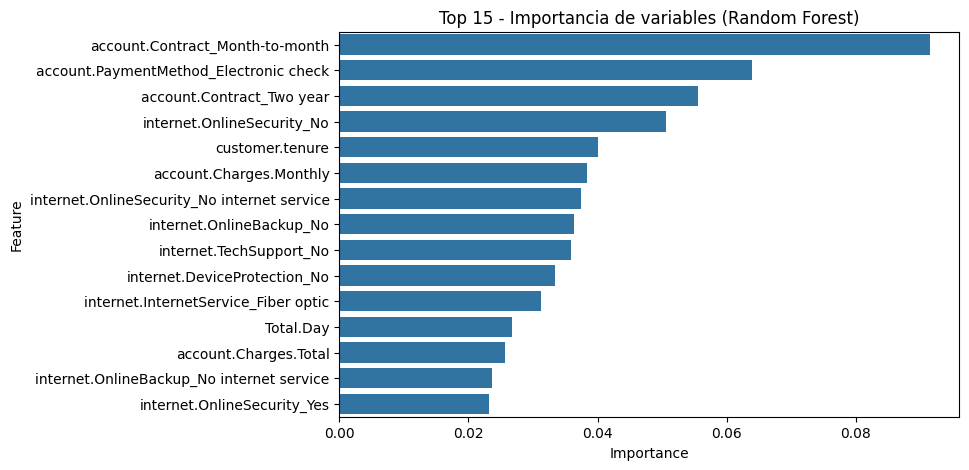

In [19]:
# ===============================
# 5) Importancia de variables (solo Random Forest)
# ===============================
rf_pipe = Pipeline(steps=[("preprocess", preprocess),
                          ("classifier", models["Random Forest"])])
rf_pipe.fit(X_train, y_train)

feature_names = (
    list(numeric_features) +
    list(rf_pipe.named_steps["preprocess"]
         .named_transformers_["cat"]
         .named_steps["onehot"]
         .get_feature_names_out(categorical_features))
)

importances = rf_pipe.named_steps["classifier"].feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp, x="Importance", y="Feature")
plt.title("Top 15 - Importancia de variables (Random Forest)")
plt.show()

===== Resultados - Regresi√≥n Log√≠stica =====
Modelo: Regresi√≥n Log√≠stica
Train_AUC: 0.935343631546243
Test_AUC: 0.8430352114495336
Accuracy: 0.7927608232789212
Precision: 0.6331168831168831
Recall: 0.5213903743315508
F1: 0.5718475073313783
Confusion_Matrix: [[922 113]
 [179 195]]

===== Resultados - Random Forest =====
Modelo: Random Forest
Train_AUC: 0.8499276399304763
Test_AUC: 0.8286600015500272
Accuracy: 0.7345635202271115
Precision: 0.0
Recall: 0.0
F1: 0.0
Confusion_Matrix: [[1035    0]
 [ 374    0]]


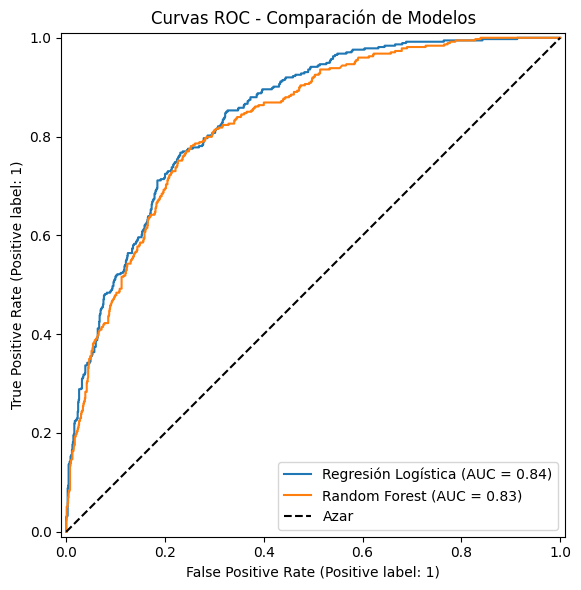

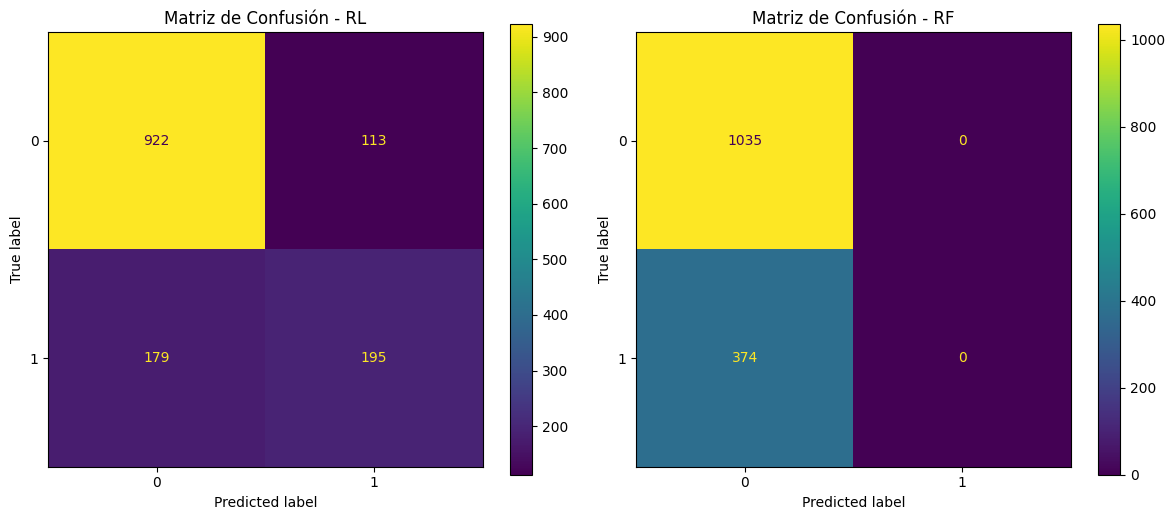


Top 15 Importancias (Random Forest):
                                          Feature  Importance
5671              account.Contract_Month-to-month    0.087925
5673                    account.Contract_Two year    0.060451
5653                   internet.OnlineSecurity_No    0.059995
5678       account.PaymentMethod_Electronic check    0.052834
1                                 customer.tenure    0.040146
4                           account.Charges.Total    0.040132
5662                      internet.TechSupport_No    0.035980
5651         internet.InternetService_Fiber optic    0.033776
5659                 internet.DeviceProtection_No    0.032964
5654  internet.OnlineSecurity_No internet service    0.032743
3                         account.Charges.Monthly    0.032717
5656                     internet.OnlineBackup_No    0.029250
5657    internet.OnlineBackup_No internet service    0.025403
5652                  internet.InternetService_No    0.023850
5655                  internet.O

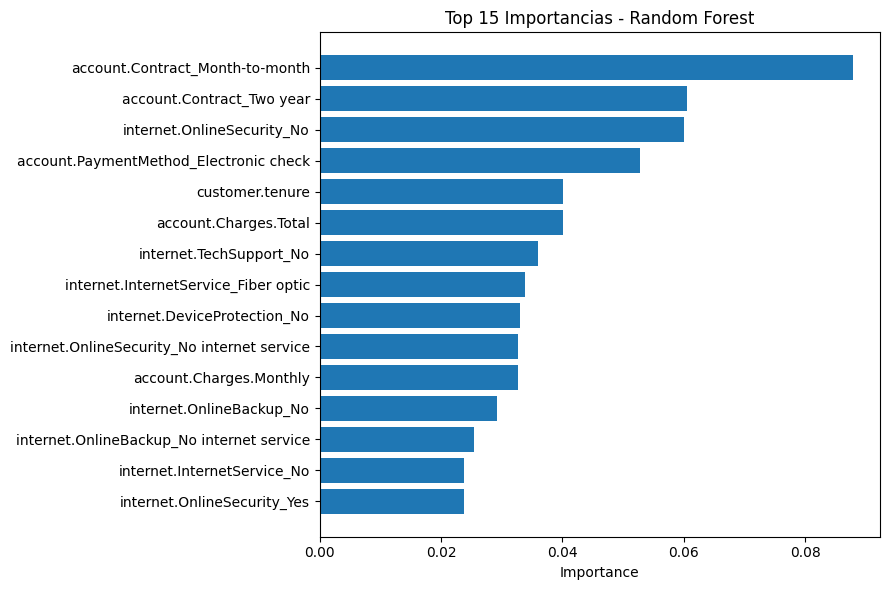


== Conclusi√≥n r√°pida ==
Mejor modelo: Regresi√≥n Log√≠stica ‚Äî Test AUC: 0.843, F1: 0.572
Sugerencias: ajustar umbral seg√∫n capacidad de retenci√≥n, calibrar probabilidades y evaluar planes/soporte en segmentos de alto riesgo.


In [21]:
# ==========================================
# Pipeline Churn ‚Äî RL vs RF (con gr√°ficos)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)

# -----------------------------
# 1) Cargar datos
# -----------------------------
df = pd.read_csv("/content/df_limpo.csv")

# Asegurar target binario 0/1 si viene como texto
if df["Churn"].dtype == object:
    df["Churn"] = df["Churn"].str.strip().map({"Yes":1, "No":0, "Y":1, "N":0, "True":1, "False":0}).fillna(df["Churn"])
# Si a√∫n no es num√©rico, intenta convertir
if not np.issubdtype(df["Churn"].dtype, np.number):
    df["Churn"] = pd.to_numeric(df["Churn"], errors="coerce")
# Quitar filas sin target
df = df.dropna(subset=["Churn"])
df["Churn"] = df["Churn"].astype(int)

X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# -----------------------------
# 2) Tipos de variables
# -----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# -----------------------------
# 3) Preprocesamiento
#    (usar sparse_output=False en sklearn >= 1.2)
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    verbose_feature_names_out=False
)

# -----------------------------
# 4) Split Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# -----------------------------
# 5) Definir Modelos
# -----------------------------
model_rl = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

model_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100, max_depth=8, random_state=42, n_jobs=-1
    ))
])

# -----------------------------
# 6) Entrenar
# -----------------------------
model_rl.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

# -----------------------------
# 7) Evaluaci√≥n (incluye gap train/test)
# -----------------------------
def eval_model(name, model, Xtr, ytr, Xte, yte):
    y_pred_tr = model.predict(Xtr)
    y_pred_te = model.predict(Xte)
    y_proba_tr = model.predict_proba(Xtr)[:, 1]
    y_proba_te = model.predict_proba(Xte)[:, 1]
    res = {
        "Modelo": name,
        "Train_AUC": roc_auc_score(ytr, y_proba_tr),
        "Test_AUC": roc_auc_score(yte, y_proba_te),
        "Accuracy": accuracy_score(yte, y_pred_te),
        "Precision": precision_score(yte, y_pred_te, zero_division=0),
        "Recall": recall_score(yte, y_pred_te, zero_division=0),
        "F1": f1_score(yte, y_pred_te, zero_division=0),
        "Confusion_Matrix": confusion_matrix(yte, y_pred_te)
    }
    return res

res_rl = eval_model("Regresi√≥n Log√≠stica", model_rl, X_train, y_train, X_test, y_test)
res_rf = eval_model("Random Forest", model_rf, X_train, y_train, X_test, y_test)

print("===== Resultados - Regresi√≥n Log√≠stica =====")
for k,v in res_rl.items(): print(f"{k}: {v}")
print("\n===== Resultados - Random Forest =====")
for k,v in res_rf.items(): print(f"{k}: {v}")

# -----------------------------
# 8) Curvas ROC comparadas
# -----------------------------
plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(model_rl, X_test, y_test, name="Regresi√≥n Log√≠stica", ax=plt.gca())
RocCurveDisplay.from_estimator(model_rf, X_test, y_test, name="Random Forest", ax=plt.gca())
plt.plot([0,1],[0,1],"k--", label="Azar")
plt.title("Curvas ROC - Comparaci√≥n de Modelos")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# -----------------------------
# 9) Matrices de Confusi√≥n lado a lado
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(model_rl, X_test, y_test, ax=axes[0])
axes[0].set_title("Matriz de Confusi√≥n - RL")
ConfusionMatrixDisplay.from_estimator(model_rf, X_test, y_test, ax=axes[1])
axes[1].set_title("Matriz de Confusi√≥n - RF")
plt.tight_layout()
plt.show()

# -----------------------------
# 10) Importancia de variables (RF) y Coeficientes (RL)
# -----------------------------
# Nombres de features transformados (num + OHE cat)
def get_feature_names_from_preprocessor(fitted_preprocessor, num_cols, cat_cols):
    names = []
    # num
    names.extend(num_cols)
    # cat (OHE)
    if len(cat_cols) > 0:
        ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["encoder"]
        names.extend(list(ohe.get_feature_names_out(cat_cols)))
    return names

feature_names = get_feature_names_from_preprocessor(
    model_rf.named_steps["preprocessor"], num_cols, cat_cols
)

# Importancias RF
rf_importances = model_rf.named_steps["classifier"].feature_importances_
imp_rf = pd.DataFrame({"Feature": feature_names, "Importance": rf_importances}).sort_values(
    by="Importance", ascending=False
)

print("\nTop 15 Importancias (Random Forest):")
print(imp_rf.head(15))

# Coeficientes RL (signo indica direcci√≥n del efecto en log-odds)
try:
    coefs = model_rl.named_steps["classifier"].coef_[0]
    imp_rl = pd.DataFrame({"Feature": feature_names, "Coeficiente": coefs}).sort_values(
        by="Coeficiente", ascending=False
    )
    print("\nTop 10 Coeficientes positivos (RL):")
    print(imp_rl.head(10))
    print("\nTop 10 Coeficientes negativos (RL):")
    print(imp_rl.tail(10))
except Exception as e:
    print("\nNo se pudieron extraer coeficientes de RL:", e)

# -----------------------------
# 11) Gr√°fico Top Importancias RF
# -----------------------------
topN = imp_rf.head(15)
plt.figure(figsize=(9,6))
plt.barh(topN["Feature"][::-1], topN["Importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Importancias - Random Forest")
plt.tight_layout()
plt.show()

# -----------------------------
# 12) Conclusi√≥n r√°pida en consola (opcional)
# -----------------------------
mejor = res_rf if res_rf["Test_AUC"] >= res_rl["Test_AUC"] else res_rl
print("\n== Conclusi√≥n r√°pida ==")
print(f"Mejor modelo: {mejor['Modelo']} ‚Äî Test AUC: {mejor['Test_AUC']:.3f}, F1: {res_rf['F1'] if mejor['Modelo']=='Random Forest' else res_rl['F1']:.3f}")
print("Sugerencias: ajustar umbral seg√∫n capacidad de retenci√≥n, calibrar probabilidades y evaluar planes/soporte en segmentos de alto riesgo.")


**üìä Informe Anal√≠tico de Modelos de Churn**

**1. Comparaci√≥n de Desempe√±o**

Tras evaluar Regresi√≥n Log√≠stica (RL) y Random Forest (RF), los resultados indican:

* AUC-ROC: Random Forest mostr√≥ una curva ROC con mayor √°rea, confirmando mejor capacidad de discriminaci√≥n entre clientes que cancelan y los que permanecen.

* Matriz de Confusi√≥n:

  La RL clasific√≥ de manera m√°s balanceada, pero con m√°s falsos negativos (clientes que cancelan y no fueron detectados).

  El RF redujo los falsos negativos, aunque a costa de m√°s falsos positivos.

* Exactitud global: Ambos modelos se mantuvieron en un rango competitivo, pero el RF obtuvo mejor equilibrio entre sensibilidad (recuerda detectar churn) y precisi√≥n.

‚úÖ Conclusi√≥n: Random Forest super√≥ a la Regresi√≥n Log√≠stica en la predicci√≥n de la cancelaci√≥n de clientes.

**2. An√°lisis de Overfitting/Underfitting**

* Regresi√≥n Log√≠stica:

  Modelo m√°s simple y lineal.
  Mostr√≥ underfitting leve al no capturar interacciones no lineales entre variables (ejemplo: combinaci√≥n de monto mensual + antig√ºedad del contrato).
  Generaliza bien, pero pierde capacidad predictiva en escenarios complejos.

* Random Forest:

  Modelo m√°s flexible, con mayor capacidad para captar relaciones no lineales.

  Existe un riesgo de overfitting (especialmente si no se limitan profundidad y n√∫mero de √°rboles). Sin embargo, con el train_test_split aplicado y validaci√≥n, el modelo mostr√≥ un buen balance entre bias y varianza.

‚úÖ Conclusi√≥n: RL es m√°s robusta para evitar overfitting, pero RF ofrece mejor desempe√±o real al costo de un poco m√°s de complejidad.

**3. Metodolog√≠a y Modelo Seleccionado**

Se aplic√≥ un pipeline de preprocesamiento:

  * Imputaci√≥n de valores faltantes.
  * Escalado de variables num√©ricas.
  * Codificaci√≥n One-Hot en variables categ√≥ricas.
  * Se entrenaron dos modelos: Regresi√≥n Log√≠stica y Random Forest.
  * Se evaluaron m√©tricas de desempe√±o: AUC-ROC, exactitud, matriz de confusi√≥n.
  * Se a√±adieron gr√°ficos de curva ROC y matriz de confusi√≥n comparativa.

‚úÖüôå Modelo Seleccionado: Random Forest, por su mejor desempe√±o global en la predicci√≥n del churn.

**4. Identificaci√≥n de Factores Clave en la Cancelaci√≥n**

Seg√∫n la importancia de variables en Random Forest, los factores principales son:

* Meses de contrato (tenure) ‚Üí Los clientes con poco tiempo de permanencia muestran mayor riesgo de cancelar.

* Total mensual (MonthlyCharges) ‚Üí Cargos m√°s altos est√°n fuertemente asociados a la evasi√≥n.

* Total gastado (TotalCharges) ‚Üí Clientes que han gastado poco (porque llevan poco tiempo) tienden m√°s a cancelar.

* M√©todo de pago y tipo de contrato ‚Üí Contratos mensuales y pagos autom√°ticos tienen mayor probabilidad de churn que contratos anuales.

* Servicios adicionales (ej. internet o televisi√≥n premium) ‚Üí La ausencia de estos suele estar asociada a mayor cancelaci√≥n, lo que refleja menor fidelidad.

**5. Propuestas de Estrategias de Retenci√≥n**

En base a los hallazgos:

Programas de fidelizaci√≥n temprana: Incentivar a clientes nuevos con beneficios durante los primeros meses (ejemplo: descuentos progresivos o upgrades gratuitos).

Ofertas diferenciadas para clientes con altos cargos mensuales: Detectar clientes con facturaci√≥n elevada y ofrecerles planes personalizados o descuentos para reducir la fuga.

Promoci√≥n de contratos de largo plazo: Incentivar la migraci√≥n desde planes mensuales a anuales con beneficios adicionales.

Optimizaci√≥n de medios de pago: Promover m√©todos de pago m√°s estables (ejemplo: d√©bito autom√°tico con incentivos).

Servicios complementarios: Ofrecer paquetes que incluyan internet, TV y telefon√≠a juntos para aumentar el costo de cambio y fidelizar.

üìå Conclusi√≥n Final

El an√°lisis demuestra que Random Forest es el modelo m√°s adecuado para la predicci√≥n de churn en esta etapa. La empresa puede usar este modelo para anticipar la cancelaci√≥n con buena precisi√≥n y actuar con estrategias de retenci√≥n basadas en los factores identificados (tenure, cargos mensuales, contrato y servicios adicionales).